## Habitat Suitability 

##### Data wrangling

Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from math import floor, ceil

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
# Merge rasters
from rioxarray.merge import merge_arrays
import xarray as xr
import xrspatial
import arcpy
from arcpy.sa import *

import matplotlib.pyplot as plt
# interactive plots of vector data
import hvplot.pandas

import earthaccess

Set Paths

In [6]:
# Images
images_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'images'
)

# Datasets
datasets_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'datasets'
)

# Project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define directories for data
land_units_dir = os.path.join(data_dir, 'usfs-national-lands')
eldorado_elevation_dir = os.path.join(data_dir, 'srtm', 'eldorado')
los_padres_elevation_dir = os.path.join(data_dir, 'srtm', 'los_padres')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(eldorado_elevation_dir, exist_ok=True)
os.makedirs(los_padres_elevation_dir, exist_ok=True)

Load Utility Functions

In [7]:
def build_da(urls, bounds):
    """Build a DataArray from a list of urls"""
    all_das = []

    # Add buffer to bounds for plotting
    buffer = .025
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    for url in urls:
        # Open data granule, mask missing data, scale data, and remove dimensions of length 1
        tile_da = rxr.open_rasterio(
                url,
                # For the fill/missing value
                mask_and_scale=True
            ).squeeze()
        # Unpack the bounds and crop tile
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        all_das.append(cropped_da)

    merged = merge_arrays(all_das)
    return merged

In [11]:
def convert_longitude(longitude):
    """Convert longitude values from a range of 0 to 360 to -180 to 180"""
    return (longitude - 360) if longitude > 180 else longitude

In [35]:
def reproject_das(das, target_da):
    """ """

    total_das = []

    for da in das:
        # Reproject the DataArray to match the resolution, projection, and region of a target DataArray 
        reprojected_da = da.rio.reproject_match(target_da)
        
        # Append the reprojected DataArray to the total_das list 
        total_das.append(reprojected_da)
    
    # Merge total_das into a single DataArray 
    merged = merge_arrays(total_das)

    # Convert DataArray to raster 
    # merged.rio.to_raster("final_site.tif")

    return merged

In [ ]:
def get_habitat_suitability(site, scenario):
    """For a given site/climate scenario combination, identify and plot suitability"""

    


    # final step: plot the raster


In [5]:
def plot_site(site_da, site_gdf, site_fig_name, plot_title, bar_label, plot_cmap, boundary_clr):
    """Create custom site plot"""
    fig = plt.figure(figsize=(8, 6)) 
    ax = plt.axes()

    # Plot DataArray values
    site_plot = site_da.plot(cmap=plot_cmap, cbar_kwargs={'label': bar_label})

    # Plot site boundary
    site_gdf.boundary.plot(ax=plt.gca(), color=boundary_clr)

    plt.title(f'{plot_title}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    fig.savefig(f"{images_dir}/{site_fig_name}.png") 

    return site_plot

Load Data

In [8]:
# Only extract once
usfs_pattern = os.path.join(land_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{datasets_dir}/S_USA.NFSLandUnit.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=land_units_dir)

# Find the extracted .shp file path
usfs_land_path = glob(usfs_pattern)[0]

# Load USFS land units from shapefile
usfs_land_units_gdf = (
    gpd.read_file(usfs_land_path)
)

# Obtain units with location name
valid_units = usfs_land_units_gdf.dropna(subset=['HQ_LOCATIO'])

# Select only CA units
all_ca_units = valid_units[valid_units['HQ_LOCATIO'].str.contains('CA')]

In [7]:
earthaccess.login(strategy="interactive", persist=True)

In [8]:
# Search for Digital Elevation Models

ea_dem = earthaccess.search_datasets(keyword='SRTM DEM', count=15)
for dataset in ea_dem:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

Explore Sites

In [9]:
# Los Padres National Forest
los_padres_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Los Padres National Forest']

# plot with EsriImagery basemap  
los_padres_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Los Padres National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [10]:
# Eldorado National Forest
eldorado_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Eldorado National Forest']

# plot with EsriImagery basemap  
eldorado_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Eldorado National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

Identify Soil Metric

In [28]:
def create_polaris_urls(soil_prop, stat, soil_depth, gdf_bounds):
    """Create POLARIS dataset urls using site bounds"""

    # Get latitude and longitude bounds from site
    min_lon, min_lat, max_lon, max_lat = gdf_bounds

    site_min_lon = floor(min_lon) 
    site_min_lat = floor(min_lat)  
    site_max_lon = ceil(max_lon)  
    site_max_lat = ceil(max_lat)

    all_soil_urls = []

    for lon in range(site_min_lon, site_max_lon): 
        for lat in range(site_min_lat, site_max_lat):
            current_max_lon = lon + 1
            current_max_lat = lat + 1

            soil_template = (
                "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
                "{soil_prop}/"
                "{stat}/"
                "{soil_depth}/"
                "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

            soil_url = soil_template.format(
                soil_prop=soil_prop, stat=stat, soil_depth=soil_depth,
                min_lat=lat, max_lat=current_max_lat, 
                min_lon=lon, max_lon=current_max_lon
            )

            all_soil_urls.append(soil_url)

    return all_soil_urls

In [29]:
# Set site parameters
soil_prop = 'ph'
soil_prop_stat = 'mean'
# cm (the minimum depth for blue oaks is 1-2 ft)
soil_depth = '30_60'

# Build soil DataArrays 

# Eldorado site
ed_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, eldorado_gdf.total_bounds)
eldorado_da = build_da(ed_polaris_urls, tuple(eldorado_gdf.total_bounds))

# Los Padres site
lp_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, los_padres_gdf.total_bounds)
los_padres_da = build_da(lp_polaris_urls, tuple(los_padres_gdf.total_bounds))

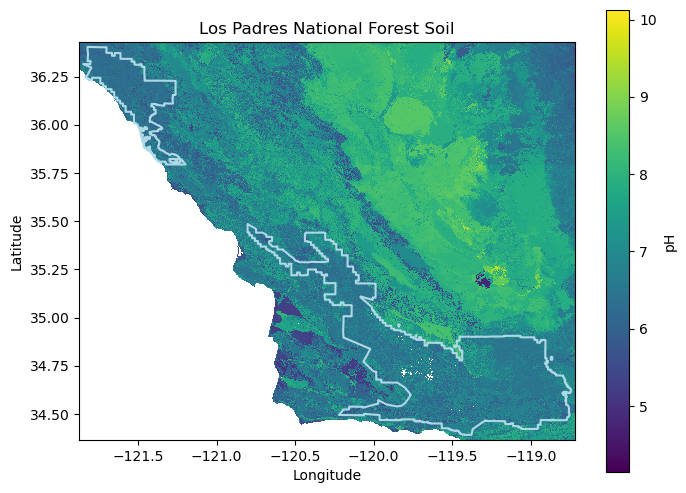

In [30]:
# Plot Los Padres soils

los_padres_soil_plt = plot_site(
    los_padres_da, los_padres_gdf, 
    'Los-Padres-National-Forest-Soil', 
    'Los Padres National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

los_padres_soil_plt

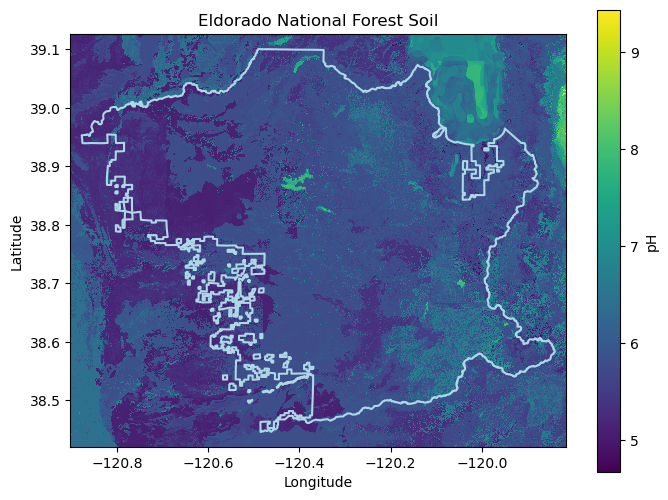

In [31]:
# Plot Eldorado soils

eldorado_soil_plt = plot_site(
    eldorado_da, eldorado_gdf, 
    'Eldorado-National-Forest-Soil', 
    'Eldorado National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

eldorado_soil_plt

Select Digital Elevation Model

In [33]:
def select_dem(bounds, site_gdf, download_dir):
    """Create elevation DataArray from NASA Shuttle Radar Topography Mission data"""

    # Returns data granules for given bounds
    strm_granules = earthaccess.search_data(
        # SRTMGL1: NASA Shuttle Radar Topography Mission Global 1 arc second V003
        short_name="SRTMGL1",
        bounding_box=bounds
    )

    # Download data granules
    earthaccess.download(strm_granules, download_dir)

    # Set SRTM data dir. hgt = height 
    strm_pattern = os.path.join(download_dir, '*.hgt.zip')

    # Build merged elevation DataArray
    strm_da = build_da(glob(strm_pattern), tuple(site_gdf.total_bounds))

    return strm_da    

In [34]:
eldorado_elev_da = select_dem(tuple(eldorado_gdf.total_bounds), eldorado_gdf, eldorado_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

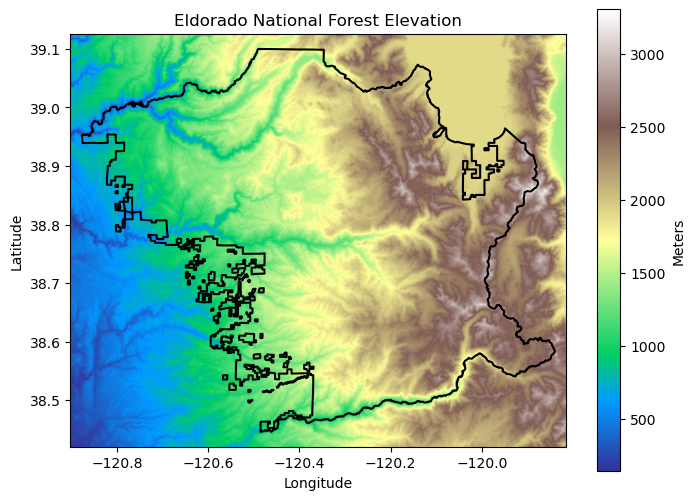

In [35]:
# Plot Eldorado elevation

eldorado_elev_plt = plot_site(
    eldorado_elev_da, eldorado_gdf, 
    'Eldorado-National-Forest-Elevation', 
    'Eldorado National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

eldorado_elev_plt

In [36]:
los_padres_elev_da = select_dem(tuple(los_padres_gdf.total_bounds), los_padres_gdf, los_padres_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

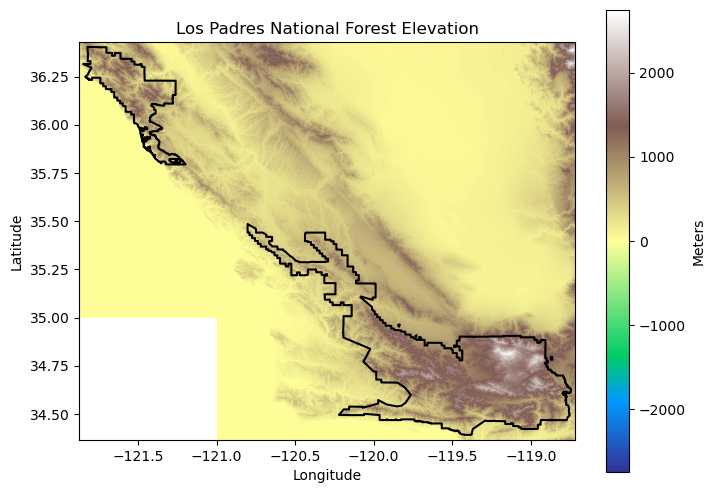

In [37]:
# Plot Los Padres elevation

los_padres_elev_plt = plot_site(
    los_padres_elev_da, los_padres_gdf, 
    'Los-Padres-Forest-Elevation', 
    'Los Padres National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

los_padres_elev_plt

Calculate Slope

In [38]:
"""
Prior to calculation, reproject to a coordinate system that uses meters as the units.

Selection: UTM (Universal Transverse Mercator) projection uses a grid system based on meter units.
For the sites, the UTM zone is 10.
"""

# EPSG code for UTM Zone 10: EPSG:32610
UTM_10_EPSG = 32610

def calculate_slope(elev_da, epsg_code):
    """Create slope DataArray from site elevation"""

    # Reproject latitude and longitude to meters for calculation
    elev_project_da = elev_da.rio.reproject(epsg_code)

    # Calculate site slope
    slope_da = xrspatial.slope(elev_project_da)

    return slope_da

In [39]:
# Calculate site slope

eldorado_slope_da = calculate_slope(eldorado_elev_da, UTM_10_EPSG)
los_padres_slope_da = calculate_slope(los_padres_elev_da, UTM_10_EPSG)

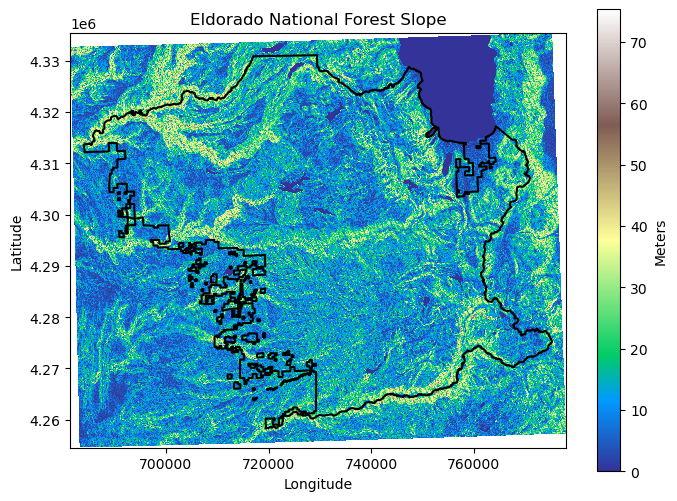

In [40]:
# Plot Eldorado slope

eldorado_slope_plt = plot_site(
    # To plot boundary, reproject from lat/long to UTM_10_EPSG
    eldorado_slope_da, eldorado_gdf.to_crs(UTM_10_EPSG), 
    'Eldorado-Forest-Slope', 
    'Eldorado National Forest Slope', 
    'Meters', 'terrain', 'black'
)

eldorado_slope_plt

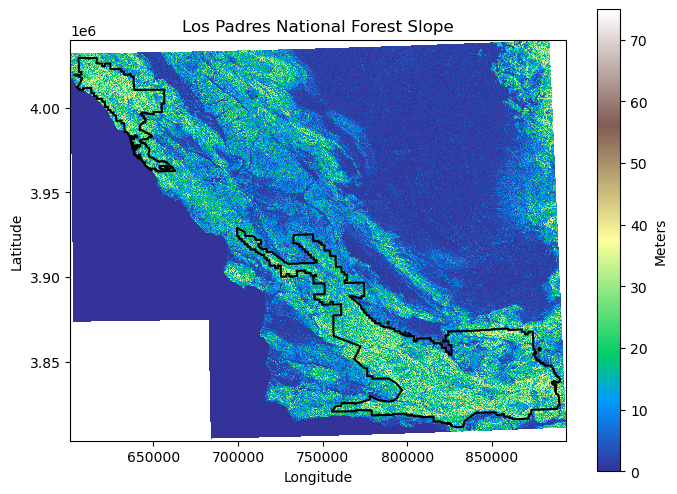

In [41]:
# Plot Los Padres slope

los_padres_slope_plt = plot_site(
    # To plot boundary, reproject from lat/long to UTM_10_EPSG
    los_padres_slope_da, los_padres_gdf.to_crs(UTM_10_EPSG), 
    'Los-Padres-Forest-Slope', 
    'Los Padres National Forest Slope', 
    'Meters', 'terrain', 'black'
)

los_padres_slope_plt

Projected Climate

*Multivariate Adaptive Constructed Analogs (MACA) is a statistical method for downscaling Global Climate Models (GCMs) from their native coarse resolution to a higher spatial resolution.*

In [30]:
def get_projected_temperature(site_gdf_dict, emissions_scenarios, start_year, end_year):
    """Create DataFrame of projected site temperature"""

    maca_da_list = []

    for site_name, site_gdf in site_gdf_dict.items():
        for scenario in emissions_scenarios:
            
            MACA_URL = (
                'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/CanESM2'
                f'/macav2metdata_tasmax_CanESM2_r1i1p1_{scenario}_{start_year}_{end_year}_CONUS_monthly.nc'
            )

            # Monthly Average of Daily Maximum Near-Surface Air Temperature
            maca_da = xr.open_dataset(MACA_URL).squeeze().air_temperature

            bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds

            # update coordinate range
            maca_da = maca_da.assign_coords(
                lon=("lon", [convert_longitude(l) for l in maca_da.lon.values])
            )

            maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

            maca_da = maca_da.rio.clip_box(*bounds)

            maca_da_list.append(dict(
                site_name=site_name,
                climate_scenario=scenario,
                da=maca_da)
            )

    maca_df = pd.DataFrame(maca_da_list)
    return maca_df 

In [31]:
# RCP 4.5 (Medium Emissions Scenario) and 8.5 (High Emissions Scenario)
emissions_scenarios = ['rcp45', 'rcp85']
site_gdf_dict = {'eldorado': eldorado_gdf, 'los padres': los_padres_gdf}
start_year = '2096'
end_year = '2099'

site_proj_temp = get_projected_temperature(site_gdf_dict, emissions_scenarios, start_year, end_year)

site_proj_temp

,site_name,climate_scenario,da
0,eldorado,rcp45,[[[<xarray.DataArray 'air_temperature' ()> Siz...
1,eldorado,rcp85,[[[<xarray.DataArray 'air_temperature' ()> Siz...
2,los padres,rcp45,[[[<xarray.DataArray 'air_temperature' ()> Siz...
3,los padres,rcp85,[[[<xarray.DataArray 'air_temperature' ()> Siz...
